# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Testing kNN with adult database from UCI repository.

**Author:** Lucas Hideki Takeuchi Okamura

**Hash:** 50

## 1. Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot import metrics as mt

from sklearn.preprocessing import RobustScaler, StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve

import warnings
warnings.filterwarnings('ignore')

## 2. Loading Dataset

In [2]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')

In [3]:
train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [4]:
test.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


We see from the datasets that the income column is the target of the problem and that's what we want to predict.

## 3. Data Description

In this section we will see a overview of the datasets, considering these subsections:

* Data Dimensions
* Data Types
* Check missing values
* Fillout missing values
* Descriptive Statistical

### 3.1. Data Dimensions

In [5]:
print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")

Training data shape: (32560, 16)
Testing data shape: (16280, 15)


### 3.2. Data Types

We can see that the income label is categorical, thus we have a classification problem.

In [6]:
train.dtypes

Id                 int64
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

### 3.3. Check and fill missing values

From the training data, we see that there are no missing data to fill.

In [7]:
train.isna().sum().sort_values(ascending = False)

income            0
native.country    0
hours.per.week    0
capital.loss      0
capital.gain      0
sex               0
race              0
relationship      0
occupation        0
marital.status    0
education.num     0
education         0
fnlwgt            0
workclass         0
age               0
Id                0
dtype: int64

### 3.4. Descriptive statistical

In this section we will have a statistical overview in the training dataset, considering numerical and categorical variables.

In [8]:
num_attributes = train.select_dtypes(include = ['int64','float64']).drop(columns = 'Id')
cat_attributes = train.select_dtypes(exclude = ['int64','float64'])

#### 3.4.1. Numerical Attributes

In [9]:
num_attributes.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Although education.num is a numeric variable, it represents the category relative to the person education level, so it will be treated as a categorical variable.

#### 3.4.2. Categorical Attributes

Here we can see how many categories each variable has, showing that native.country is the feature with most categories.

In [10]:
# inserting education.num to categorical variables
new_cat_variables = list(cat_attributes.columns) + ['education.num']
cat_attributes = train[new_cat_variables].copy()

# removing education.num from numerical variables
num_attributes = num_attributes.drop(columns = 'education.num')

In [11]:
cat_attributes.apply(lambda x: x.unique().shape[0])

workclass          9
education         16
marital.status     7
occupation        15
relationship       6
race               5
sex                2
native.country    42
income             2
education.num     16
dtype: int64

## 4. Exploratory Data Analysis

Here the data characteristics will be summarized and understood from plots and statistical inferences.

### 4.1. Univariate Analysis

#### 4.1.1. Response Variable (income)

Plotting a barplot to understand how the target variable is distributed. It is possible to see that the training dataset is unbalanced relative to the target labels, as the people who have a income <=50K is the majority when compared to those who have income >50K.

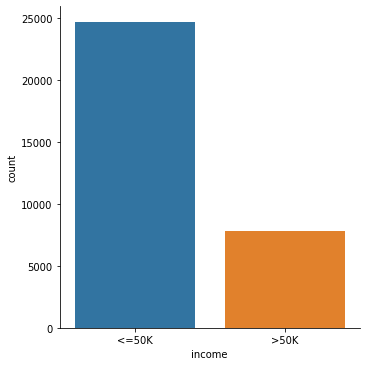

In [12]:
_ = sns.catplot(x = 'income', kind = 'count', data = train)

#### 4.1.2. Numerical Variable

We can infere some informations from the graphs:

* **age**: most part of the people have less than 60 years
* **fnlwgt**: almost all the data concentrated in values less than $0.75 * 10^{6}$, despite some outliers
* **capital.gain** and **capital.loss**: values are concentrated near 0, despite some outliers
* **hours.per.week**: values are concentrated near 40, an it has a lot of outliers

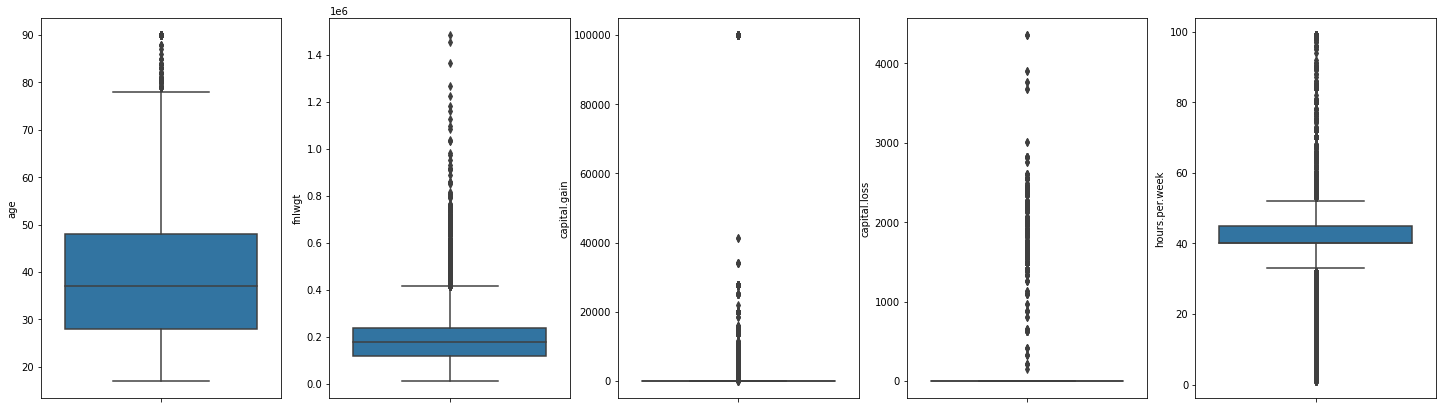

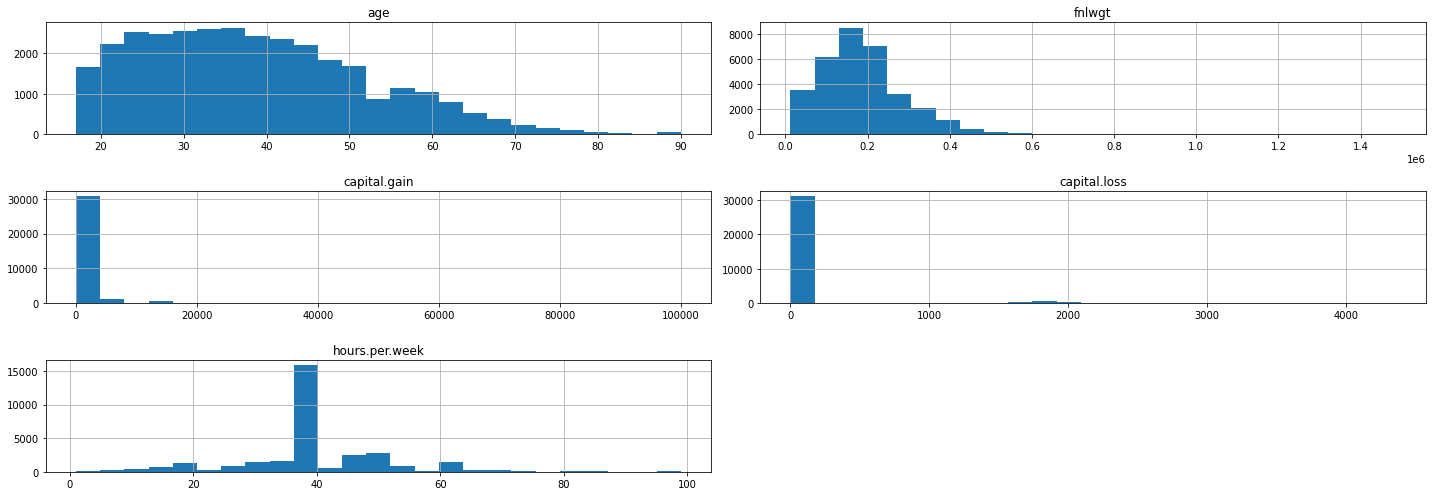

In [13]:
fig, ax = plt.subplots(1, 5, figsize = (25,7))
for index, column in enumerate(num_attributes.columns):
    _ = sns.boxplot(y = num_attributes[column], ax = ax[index], orient = 'v')
    
_ = num_attributes.hist(bins = 25, figsize = (20, 7))
_ = plt.tight_layout()

#### 4.1.3. Categorical Variable

From the data, we can infere:

* **workclass**: the majority of the public studied in private schools
* **education**: the most significant categories are HS-grad, Bachelors and Some College
* **marital.status**: Married-civ-spouse and Never-married are predominant
* **occupation**: this features has a well distributed data
* **relationship**: Husband predominates
* **race**: most part of the public is white
* **sex**: more men were asked than women
* **native.country**: clear predominance of american people
* **education.num**: class 9 predominates

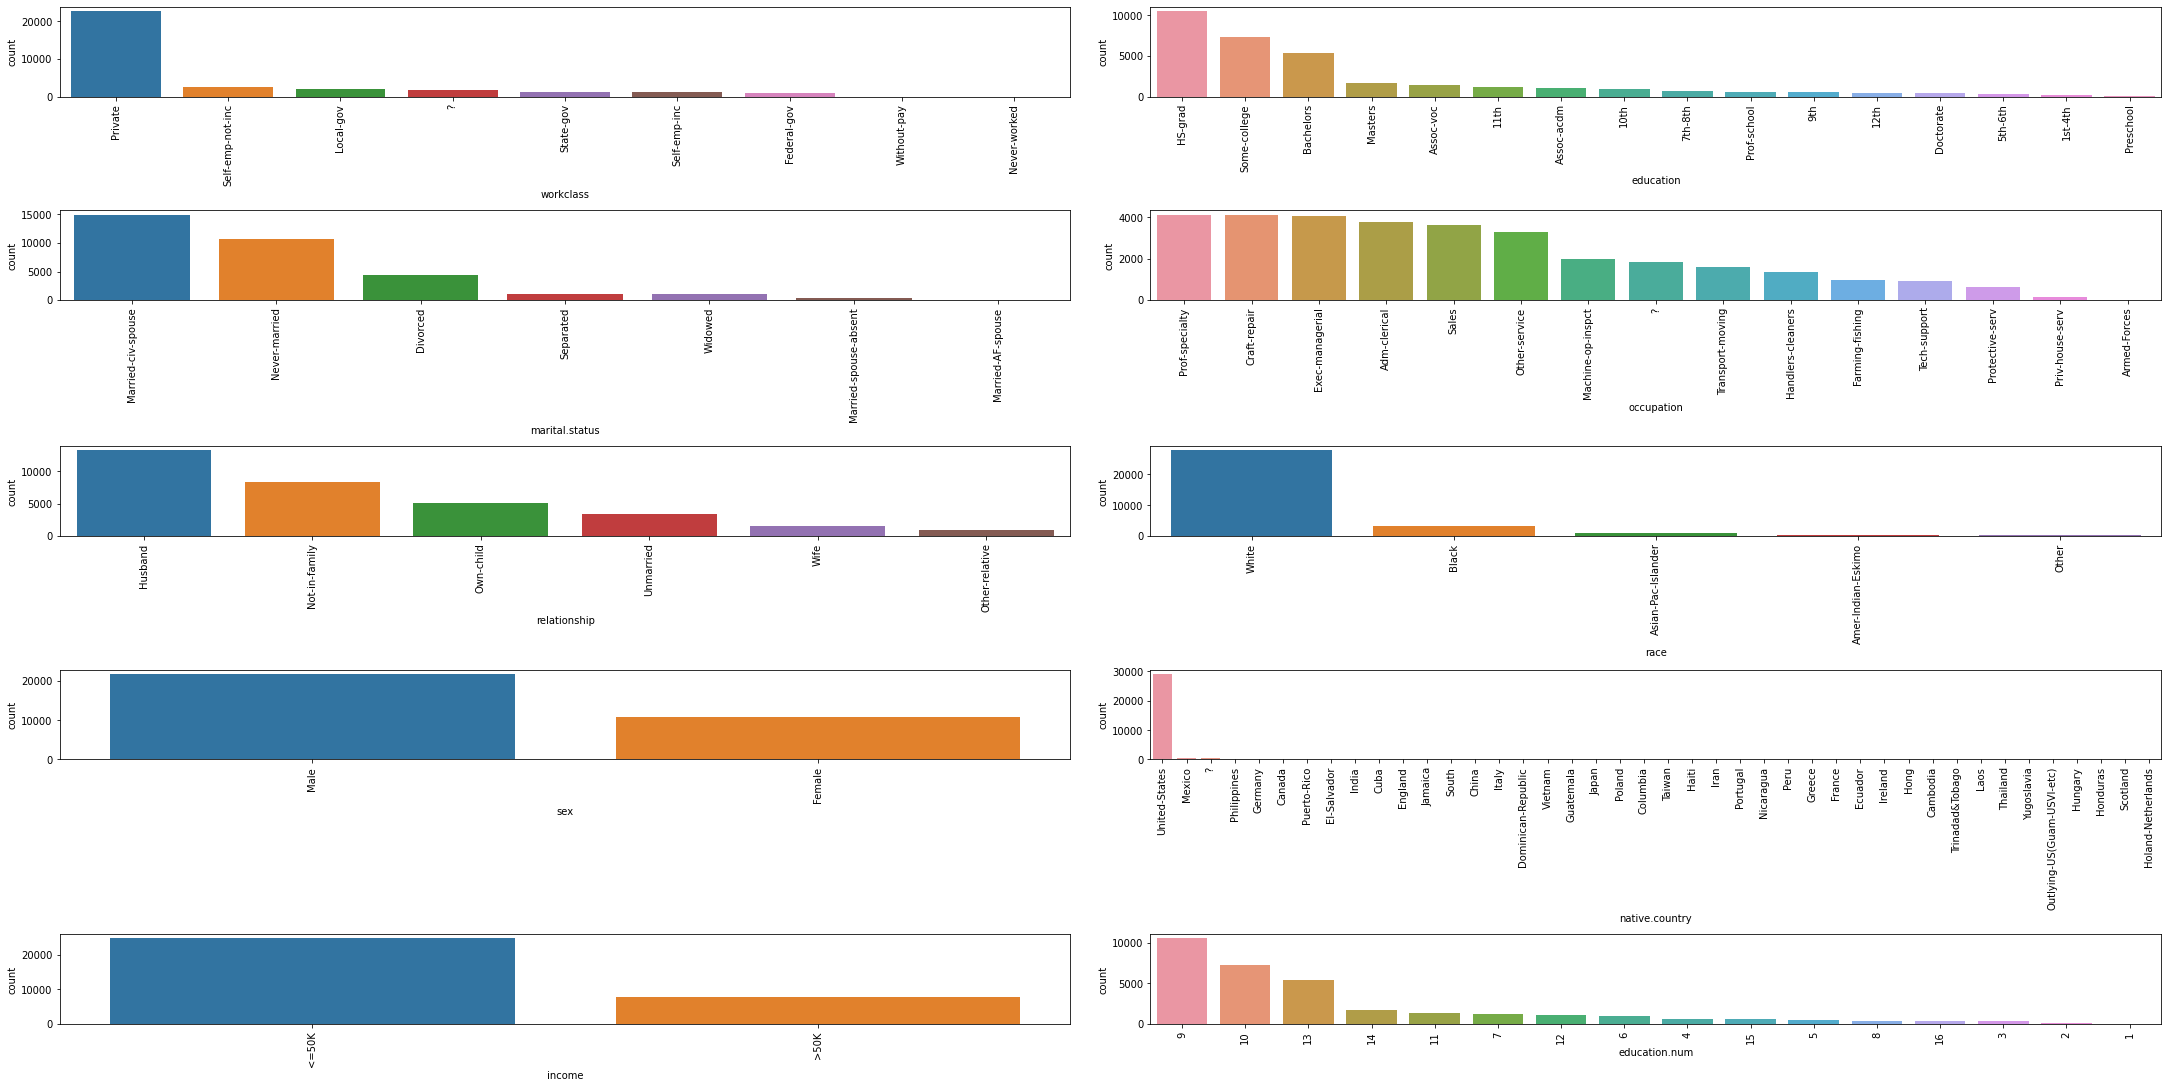

In [14]:
fig, axes = plt.subplots(5, 2, figsize = (30,15), constrained_layout=True)
axes = axes.flatten()

for index, column in enumerate(cat_attributes.columns):
    _ = sns.countplot(cat_attributes[column], ax = axes[index], order = cat_attributes[column].value_counts().index)
    axes[index].tick_params(axis='x', rotation=90)

### 4.2. Bivariate Analysis

Now, some features will be evaluated relative to their relation to the target variable income.

#### 4.2.1. sex - income comparison

From the graphs we see that the proportion between men and woman is different when the income is considered. While there are, proportionaly more men than women in the >50K class, this proportion reduces when the class <=50K is considered, evidencing that men are more prone to have a income bigger than 50K.

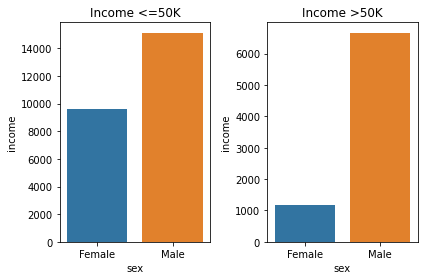

In [15]:
# separating publics by income
less_income = train[train['income'] == '<=50K']
less_income = less_income[['sex','income']].groupby("sex").count().reset_index()

more_income = train[train['income'] == '>50K']
more_income = more_income[['sex','income']].groupby("sex").count().reset_index()

# plot 1 - income <=50K
plt.subplot(1,2,1)
_ = sns.barplot(x = 'sex', y = 'income', data = less_income)
_ = plt.title("Income <=50K")

#plot2 - gender x cardio (bar plot)
plt.subplot(1,2,2)
_ = sns.barplot(x = 'sex', y = 'income', data = more_income)
_ = plt.title("Income >50K")

_ = plt.tight_layout()

#### 4.2.2. age - income comparison

Although the correlation between age and income is quite low, it is possible to see a slight trend that older people have higher incomes.

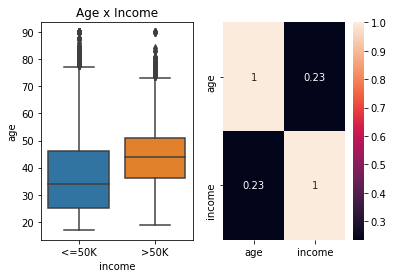

In [16]:
# plot 1 - boxplot
plt.subplot(1,2,1)
_ = sns.boxplot(x = 'income', y = 'age', data = train)
_ = plt.title("Age x Income")

# plot 2 - correlation
plt.subplot(1,2,2)
df_corr = train[['age', 'income']]
df_corr['income'] = df_corr['income'].map({'<=50K' : 0, '>50K' : 1})
_ = sns.heatmap(df_corr[['age', 'income']].corr(method = 'pearson'), annot = True)

#### 4.2.3. education - income comparison

From the data, we see that the majority of people with income less than 50K has only completed High School or some college, while people with bachelor dominates in the higher income public.

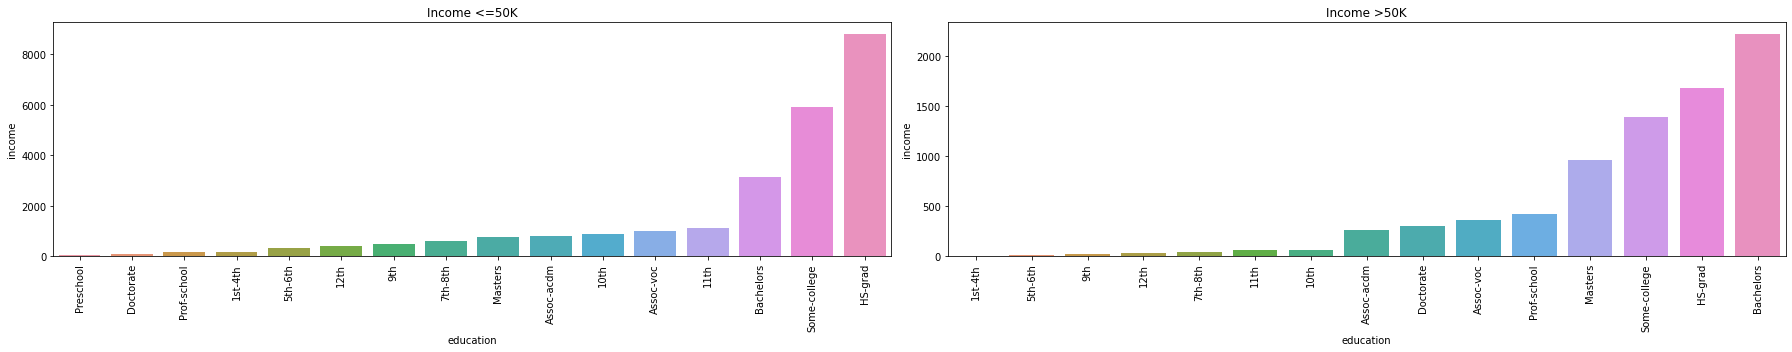

In [17]:
# separating publics by income
less_income = train[train['income'] == '<=50K']
less_income = less_income[['education','income']].groupby("education").count().sort_values('income').reset_index()

more_income = train[train['income'] == '>50K']
more_income = more_income[['education','income']].groupby("education").count().sort_values('income').reset_index()

fig, axes = plt.subplots(1,2,figsize = (25, 5))

# plot 1 - income <=50K
_ = sns.barplot(x = 'education', y = 'income', data = less_income, ax = axes[0])
_ = axes[0].set_title("Income <=50K")
_ = axes[0].tick_params(axis='x', rotation=90)

#plot2 - gender x cardio (bar plot)
_ = sns.barplot(x = 'education', y = 'income', data = more_income, ax = axes[1])
_ = axes[1].set_title("Income >50K")
_ = axes[1].tick_params(axis='x', rotation=90)

_ = plt.tight_layout()

### 4.3. Multivariate Analysis

From the multivariate analysis, we look for features that are not correlated to others features and features that are somehow correlated to the target, in order to predict the result more accurately basing on those correlations. From the heatmap, we see that none of the features have a high correlation to each other and age, education.num, capital.gain and hours.per.week have decent correlation to the target variable income, indicating that they are good variables to the model.

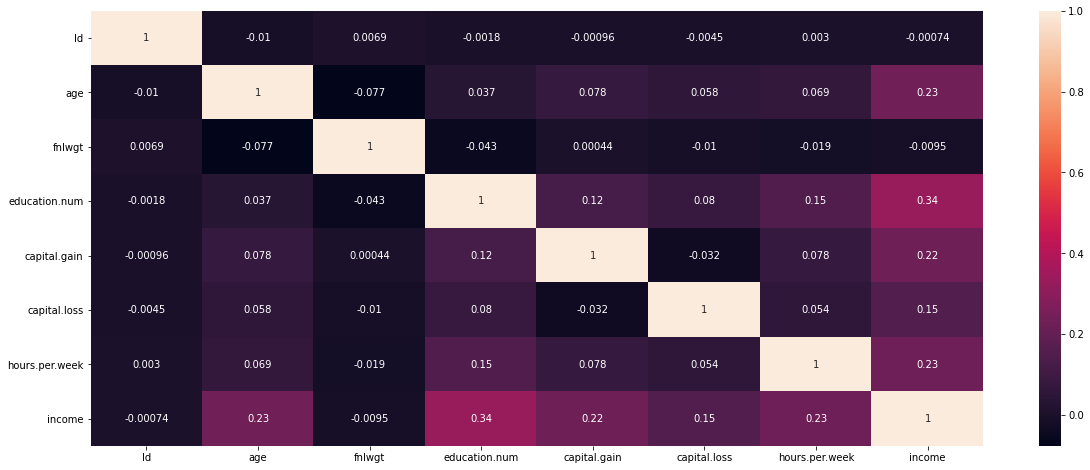

In [18]:
#exclude non-numerical variables
df_corr = train.copy()
df_corr['income'] = df_corr['income'].map({'<=50K' : 0, '>50K' : 1})
aux1 = df_corr.select_dtypes(exclude = ['object'])

#plot correlation plot to our numerical variables
fig, ax = plt.subplots(figsize = (20, 8))
_ = sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = ax)

## 5. Feature Engineering

We will create a variable called "capital", which is calculated by capital.gain - capital.loss:

In [19]:
train['capital'] = train['capital.gain'] - train['capital.loss']
test['capital'] = test['capital.gain'] - test['capital.loss']

In [20]:
train[['capital']].describe()

,capital
count,32560.000000
mean,990.308661
std,7409.097824
min,-4356.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,99999.000000


## 6. Feature Selection

Since the majority of the public is from United States, we will drop native.country, that will not bring a lot of information. And since we created a new variable "capital", we will drop "capital.gain" and "capital.loss".

In [21]:
train = train.drop(columns = ['native.country', 'capital.gain', 'capital.loss'])
test = test.drop(columns = ['native.country', 'capital.gain', 'capital.loss'])

## 7. Data Preparation

In [22]:
X = train.drop(columns = ['income', 'Id'])
y = train['income'].copy()

#split data into training and test dataset
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.20, random_state = 42)

databases = [X, X_train, X_val, test]

### 7.1. Rescaling

Due to the outliers, we will use RobustScaler to rescale the numeric data, since it is not sensitive to outliers.

In [23]:
rs = RobustScaler()
columns = X_train.drop(columns = ['education.num']).select_dtypes(include = ['int64','float64']).columns
print(columns)
for base in databases:
    base[columns] = rs.fit_transform(base[columns].values)

Index(['age', 'fnlwgt', 'hours.per.week', 'capital'], dtype='object')


In [24]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,capital
24639,0.60,Private,-0.085284,5th-6th,3,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0
5514,-0.25,Private,0.020078,Assoc-voc,11,Divorced,Sales,Not-in-family,White,Male,2.0,0.0
19777,0.15,Private,-0.567096,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0
10781,-0.40,Federal-gov,1.349343,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0
32239,-0.85,Private,-0.297748,Some-college,10,Never-married,Farming-fishing,Own-child,White,Male,0.0,0.0


### 7.2. Encoding

We will apply the following encoding to the features:

* **OrdinalEncoder**: workclass, education, marital.status, occupation, relationship, race

* **OneHotEncoder**: sex

education.num is already encoded.

In [25]:
X_train.select_dtypes(include = 'object').apply(lambda x: x.unique().shape[0])

workclass          9
education         16
marital.status     7
occupation        15
relationship       6
race               5
sex                2
dtype: int64

In [26]:
label_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race']
onehot_columns = ['sex']

for base in databases:
    # OrdinalEncoder
    le = OrdinalEncoder()
    base[label_columns] = le.fit_transform(base[label_columns])
    
# OneHotEncoder
X = pd.get_dummies(X, prefix=onehot_columns, columns = onehot_columns, drop_first=True)
X_train = pd.get_dummies(X_train, prefix=onehot_columns, columns = onehot_columns, drop_first=True)
X_val = pd.get_dummies(X_val, prefix=onehot_columns, columns = onehot_columns, drop_first=True)
test = pd.get_dummies(test, prefix=onehot_columns, columns = onehot_columns, drop_first=True)

In [27]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,hours.per.week,capital,sex_Male
24639,0.60,4.0,-0.085284,4.0,3,2.0,3.0,0.0,4.0,0.0,0.0,1
5514,-0.25,4.0,0.020078,8.0,11,0.0,12.0,1.0,4.0,2.0,0.0,1
19777,0.15,4.0,-0.567096,11.0,9,5.0,7.0,1.0,4.0,0.0,0.0,0
10781,-0.40,1.0,1.349343,8.0,11,2.0,3.0,0.0,4.0,0.0,0.0,1
32239,-0.85,4.0,-0.297748,15.0,10,4.0,5.0,3.0,4.0,0.0,0.0,1


## 8. Machine Learning Modelling and Hyperparameter Tunning

From GridSearchCV, we see that the best kNN estimator is the one with 20 neighbors, which ahs a cross-validation score of 0.859.

In [28]:
# model definition
knn = KNeighborsClassifier()

# GridSearch CV
parameters = {'n_neighbors' : np.arange(5, 31, 5)}
knn_grid_cv = GridSearchCV(knn, parameters, verbose = True, cv = 5)
knn_grid_cv.fit(X_train, y_train)

print(f'Best estimator: {knn_grid_cv.best_estimator_}')
print(f'Best score: {knn_grid_cv.best_score_}')

# predict
y_predict = knn_grid_cv.predict(X_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best estimator: KNeighborsClassifier(n_neighbors=20)
Best score: 0.858530153591396


### 8.1. Model Performance

It is possible to see that the model identifies the majority of the public who has a income less than 50K, but it's performance related to those with income higher than 50K is not so good, as the recall shows, saying that among all the people in the validation set who has a income higher than 50K, the model can identify only 63% of them.

In [29]:
#classification_report
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      4974
        >50K       0.75      0.63      0.68      1538

    accuracy                           0.86      6512
   macro avg       0.82      0.78      0.80      6512
weighted avg       0.86      0.86      0.86      6512



From the confusion, we see that there are more False Negatives than False Positives, indicating that our model conservative when predicting if someone has a income higher than 50K. This can be explained possibly by the unbalanced dataset.

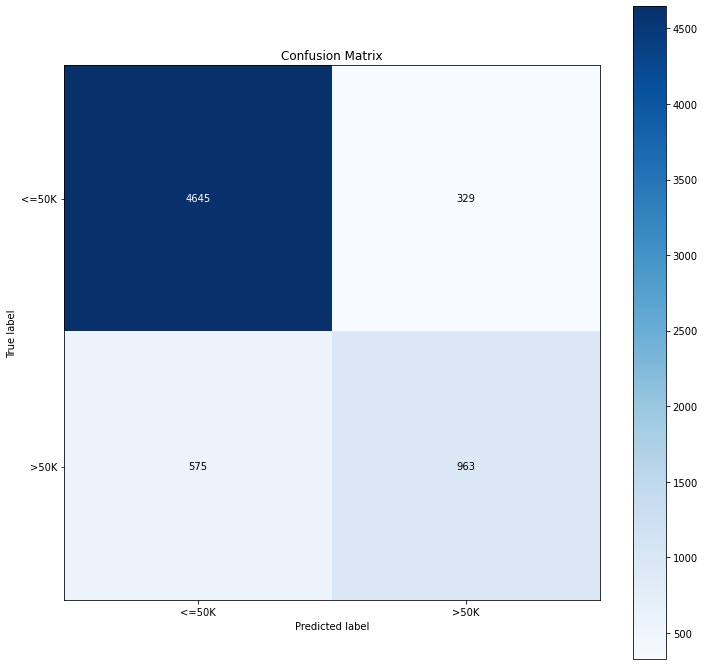

In [30]:
#confusion_matrix
_ = mt.plot_confusion_matrix(y_val,y_predict, normalize = False, figsize = (12,12))

### 8.2. Fitting the model using all the data and the best parameters

In [31]:
# model definition
best_knn = KNeighborsClassifier(n_neighbors=20)

# fitting model
best_knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

### 8.3. Predicting

In [32]:
# predict
test['income'] = best_knn.predict(test.drop(columns = 'Id'))

test.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,hours.per.week,capital,sex_Male,income
0,0,-0.60,4.0,-0.470408,9.0,13,4.0,10.0,1.0,4.0,0.8,0.0,1,<=50K
1,1,1.35,7.0,-0.207882,9.0,13,2.0,4.0,0.0,4.0,1.0,0.0,1,>50K
2,2,-0.30,4.0,-0.638579,12.0,14,0.0,4.0,1.0,4.0,0.0,0.0,0,>50K
3,3,0.40,4.0,0.092822,11.0,9,4.0,7.0,3.0,4.0,0.0,0.0,1,<=50K
4,4,1.35,5.0,2.547277,9.0,13,2.0,4.0,0.0,4.0,2.0,0.0,1,>50K


## 9. Exporting result

In [33]:
export_path = "./submissions/submission.csv"
test[['Id', 'income']].to_csv(export_path, index = False)